In [1]:
# pip install transformers
# pip install torch
# pip install scikit-learn tensorflow bs4

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from datetime import datetime, timedelta
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import requests
from bs4 import BeautifulSoup

In [3]:
# 그래프 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [4]:
# 네이버 API 인증 정보
client_id = 'YaKyDrFyIZDRfIiRAwBj'
client_secret = 'hknmr5WHGm'

In [5]:
# 현재 시간
now = datetime.now()

# 분이 30분 이상인지 확인
if now.minute >= 30:
    # 30분 이상이면 다음 시간으로 반올림
    rounded_time = now.replace(minute=0, second=0, microsecond=0) + timedelta(hours=1)
else:
    # 30분 미만이면 현재 시간에서 분, 초, 마이크로초를 0으로 설정
    rounded_time = now.replace(minute=0, second=0, microsecond=0)

# 원하는 형식으로 출력
formatted_time = rounded_time.strftime("%Y-%m-%d %H:%M:%S")
print("반올림된 시간:", formatted_time)

반올림된 시간: 2024-12-18 12:00:00


In [6]:
# 업비트 데이터를 가져오는 함수
def fetch_upbit_data(market="KRW-BTC", count=200, minutes=60):
    url = f"https://api.upbit.com/v1/candles/minutes/{minutes}"
    params = {"market": market, "count": count, "to": formatted_time}
    response = requests.get(url, params=params)

    if response.status_code != 200:
        print(f"업비트 API에서 데이터를 가져오지 못했습니다. 상태 코드: {response.status_code}")
        return None

    data = response.json()
    df = pd.DataFrame(data)
    df = df[["candle_date_time_kst", "trade_price"]]
    df.columns = ["time", "price"]
    # df["date"] = pd.to_datetime(df["date"]).dt.date
    df["time"] = pd.to_datetime(df["time"]) # 방금 추가 
    df.sort_values(by="time", inplace=True)
    return df

In [7]:
# 뉴스 데이터를 가져오는 함수
def fetch_news_data(query, display=10):
    url = f"https://openapi.naver.com/v1/search/news.json?query={query}&display={display}"
    headers = {
        "X-Naver-Client-Id": client_id,
        "X-Naver-Client-Secret": client_secret
    }
    response = requests.get(url, headers=headers)

    if response.status_code != 200:
        print(f"뉴스 API에서 데이터를 가져오지 못했습니다. 상태 코드: {response.status_code}")
        return None

    data = response.json()
    return pd.DataFrame(data['items'])

In [8]:
# 감정 분석을 위한 함수
def analyze_sentiment(texts):
    tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
    model = AutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
    sentiments = []

    for text in texts:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
        outputs = model(**inputs)
        sentiment = torch.argmax(outputs.logits, dim=1).item() + 1  # 감정 점수: 1~5
        sentiments.append(sentiment)

    return sentiments

In [9]:
# URL에서 뉴스 제목과 본문을 크롤링하는 함수
def crawl_additional_news(url):
    response = requests.get(url)
    if response.status_code != 200:
        print(f"뉴스 크롤링 실패: 상태 코드 {response.status_code}")
        return None, None

    soup = BeautifulSoup(response.text, "html.parser")
    title_tag = soup.find("h1") or soup.find("title")
    content_tag = soup.find("div", class_="content") or soup.find("article")

    title = title_tag.text.strip() if title_tag else "제목 없음"
    content = content_tag.text.strip() if content_tag else "본문 없음"
    return title, content

In [10]:
# BTC/KRW 시장 데이터 가져오기
df_price = fetch_upbit_data()
if df_price is None:
    raise ValueError("업비트 데이터를 가져오지 못했습니다.")

In [11]:
df_price

,time,price
199,2024-12-10 05:00:00,137213000.0
198,2024-12-10 06:00:00,138397000.0
197,2024-12-10 07:00:00,138380000.0
196,2024-12-10 08:00:00,138864000.0
195,2024-12-10 09:00:00,139005000.0
...,...,...
4,2024-12-18 08:00:00,155223000.0
3,2024-12-18 09:00:00,155010000.0
2,2024-12-18 10:00:00,154396000.0
1,2024-12-18 11:00:00,153865000.0


In [12]:
# 뉴스 데이터 가져오기
news_df = fetch_news_data("비트코인")
if news_df is None:
    raise ValueError("뉴스 데이터를 가져오지 못했습니다.")

In [13]:
# 뉴스 데이터 날짜별 처리
news_df['pubDate'] = pd.to_datetime(news_df['pubDate'], errors='coerce')
# news_df['date'] = news_df['pubDate'].dt.date
news_df.dropna(subset=['pubDate'], inplace=True)
# news_df = news_df.dropna(subset=['date'])

In [14]:
# 감정 분석 수행
news_df['sentiment'] = analyze_sentiment(news_df['title'])
news_df['time'] = news_df['pubDate'].dt.floor('h').dt.tz_localize(None)  # 시간 단위로 리샘플링

In [15]:
# 크롤링할 뉴스 URL 리스트
news_urls = [
    "https://www.g-enews.com/ko-kr/news/article/news_all/202312031530096281e7e8286d56_1/article.html",
    "https://www.yna.co.kr/view/AKR20231007023200002?input=1195m",
    "https://www.hankyung.com/article/2023100952301",
    # 추가 URL을 여기에 입력 가능
]

In [16]:
#추가 뉴스 크롤링 및 데이터 추가
for url in news_urls:
    additional_title, additional_content = crawl_additional_news(url)
    if additional_title:
        additional_sentiment = analyze_sentiment([additional_title])[0]
        print(f"추가 뉴스 제목: {additional_title}")
        print(f"추가 뉴스 감정 점수: {additional_sentiment}")
        # 추가된 뉴스 데이터를 기존 데이터프레임에 병합
        news_df = pd.concat([news_df, pd.DataFrame({"time": [pd.Timestamp.now().floor('h').tz_localize(None)],
                                                    "title": [additional_title],
                                                    "sentiment": [additional_sentiment]})], ignore_index=True)


추가 뉴스 제목: 일론 머스크 관련 ‘밈 토큰’ 급등…가상화폐 생태계 흔들까
추가 뉴스 감정 점수: 3
추가 뉴스 제목: 상반기 국내 가상자산 시총 28조…비트코인 등 회복세에 46%↑
추가 뉴스 감정 점수: 1
추가 뉴스 제목: 금융
추가 뉴스 감정 점수: 4


In [17]:
# # 날짜별 평균 감정 점수 계산
# sentiment_by_date = news_df.groupby('date')['sentiment'].mean().reset_index()
# sentiment_by_date.columns = ['date', 'average_sentiment']

# 시간 단위 평균 감정 점수 계산
sentiment_by_time = news_df.groupby('time')['sentiment'].mean().reset_index()

In [18]:
# 시세 데이터와 감정 점수 병합
merged_df = pd.merge(df_price, sentiment_by_time, on='time', how='left')

# 결측값 처리
merged_df['sentiment'] = merged_df['sentiment'].fillna(2.5)

In [20]:
# 각각의 스케일러 생성
price_scaler = MinMaxScaler()
sentiment_scaler = MinMaxScaler()

merged_df['scaled_price'] = price_scaler.fit_transform(merged_df['price'].values.reshape(-1, 1))
merged_df['scaled_sentiment'] = sentiment_scaler.fit_transform(merged_df['sentiment'].values.reshape(-1, 1))

# scaler.fit(df_price[['price']])
# merged_df['scaled_price'] = scaler.transform(merged_df['price'].values.reshape(-1, 1))
# merged_df['scaled_sentiment'] = scaler.transform(merged_df['average_sentiment'].values.reshape(-1, 1))

In [21]:
merged_df

,time,price,sentiment,scaled_price,scaled_sentiment
0,2024-12-10 05:00:00,137213000.0,2.500000,0.029652,0.375
1,2024-12-10 06:00:00,138397000.0,2.500000,0.087206,0.375
2,2024-12-10 07:00:00,138380000.0,2.500000,0.086380,0.375
3,2024-12-10 08:00:00,138864000.0,2.500000,0.109907,0.375
4,2024-12-10 09:00:00,139005000.0,2.500000,0.116761,0.375
...,...,...,...,...,...
195,2024-12-18 08:00:00,155223000.0,2.500000,0.905114,0.375
196,2024-12-18 09:00:00,155010000.0,2.500000,0.894760,0.375
197,2024-12-18 10:00:00,154396000.0,2.500000,0.864913,0.375
198,2024-12-18 11:00:00,153865000.0,2.400000,0.839102,0.000


In [22]:
# 멀티모달 데이터 생성 함수 정의
def create_multimodal_sequences(prices, sentiments, seq_length):
    sequences = []
    labels = []
    for i in range(len(prices) - seq_length):
        seq = np.column_stack((prices[i:i + seq_length], sentiments[i:i + seq_length]))
        label = prices[i + seq_length]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

In [23]:
# 멀티모달 데이터 준비
sequence_length = 15
X, y = create_multimodal_sequences(
    merged_df['scaled_price'].values,
    merged_df['scaled_sentiment'].values,
    sequence_length
)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
from tensorflow.keras import Input

# GRU 모델 생성
model = Sequential([
    Input(shape=(sequence_length, 2)),  # 입력 레이어
    GRU(256, return_sequences=True),  # 첫 번째 GRU 층
    Dropout(0.3),                    
    GRU(128, return_sequences=True),  # 두 번째 GRU 층 추가
    Dropout(0.3),
    GRU(64),                          # 마지막 GRU 층
    Dropout(0.2),
    Dense(32, activation='relu'),     # Dense 층 추가 (비선형 학습 강화)
    Dense(1)       # 출력층
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae', 'mape'])

In [25]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 콜백 설정
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True,
    min_delta=1e-4
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

# 모델 학습
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 350ms/step - loss: 0.3026 - mae: 0.4790 - mape: 574440.6875 - val_loss: 0.0322 - val_mae: 0.1304 - val_mape: 36.5048 - learning_rate: 0.0010
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0412 - mae: 0.1663 - mape: 2409124.5000 - val_loss: 0.0628 - val_mae: 0.2430 - val_mape: 97.9085 - learning_rate: 0.0010
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0550 - mae: 0.2099 - mape: 3942900.5000 - val_loss: 0.0142 - val_mae: 0.0875 - val_mape: 26.0875 - learning_rate: 0.0010
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0254 - mae: 0.1217 - mape: 1121881.8750 - val_loss: 0.0290 - val_mae: 0.1312 - val_mape: 25.7945 - learning_rate: 0.0010
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0339 - mae: 0.1505 - mape: 462682.3438 - val_loss: 0.0056 - val_mae: 0.0543 - val_mape: 14.6622 - learning_rate: 0.0010
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0117 - mae: 0.0791 - mape: 1504614.1

In [29]:
# 예측값과 실제값 복원
predictions = model.predict(X_test)
original_scale_predictions = price_scaler.inverse_transform(predictions)
original_scale_y_test = price_scaler.inverse_transform(y_test.reshape(-1, 1))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


In [31]:
# 결과 출력
print("샘플 예측값과 실제값:") 
for pred, true in zip(original_scale_predictions[:5], original_scale_y_test[:5]):
    print(f"예측값: {pred[0]:,.2f}, 실제값: {true[0]:,.2f}")
    print(f"예측값: {pred[0]:.4f}, 실제값: {true[0]:.4f}") # 방금 추가

샘플 예측값과 실제값:
예측값: 138,350,784.00, 실제값: 138,949,000.00
예측값: 138350784.0000, 실제값: 138949000.0000
예측값: 143,590,192.00, 실제값: 142,693,000.00
예측값: 143590192.0000, 실제값: 142693000.0000
예측값: 153,395,696.00, 실제값: 153,403,000.00
예측값: 153395696.0000, 실제값: 153403000.0000
예측값: 146,145,792.00, 실제값: 146,340,000.00
예측값: 146145792.0000, 실제값: 146340000.0000
예측값: 151,383,984.00, 실제값: 153,921,000.00
예측값: 151383984.0000, 실제값: 153921000.0000


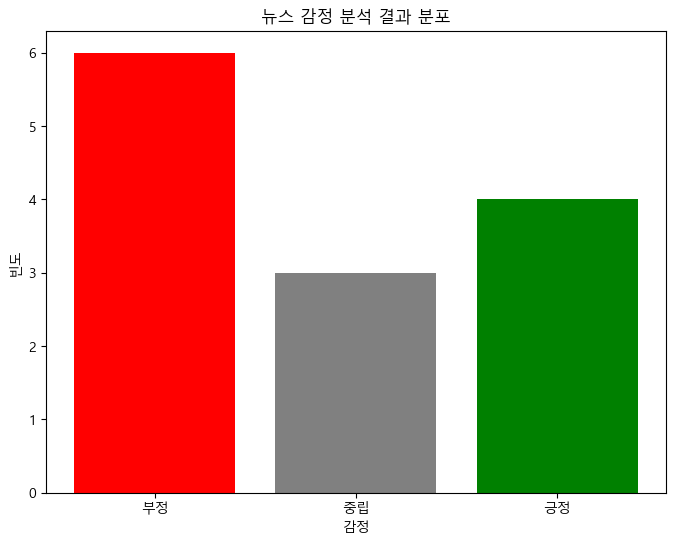

In [32]:
# 뉴스 감정 분석 결과 시각화
sentiment_counts = news_df['sentiment'].value_counts().sort_index()
categories = ['부정', '중립', '긍정']
counts = [
    sentiment_counts.get(1, 0) + sentiment_counts.get(2, 0),
    sentiment_counts.get(3, 0),
    sentiment_counts.get(4, 0) + sentiment_counts.get(5, 0)
]
plt.figure(figsize=(8, 6))
plt.bar(categories, counts, color=['red', 'gray', 'green'])
plt.title('뉴스 감정 분석 결과 분포')
plt.xlabel('감정')
plt.ylabel('빈도')
plt.show()

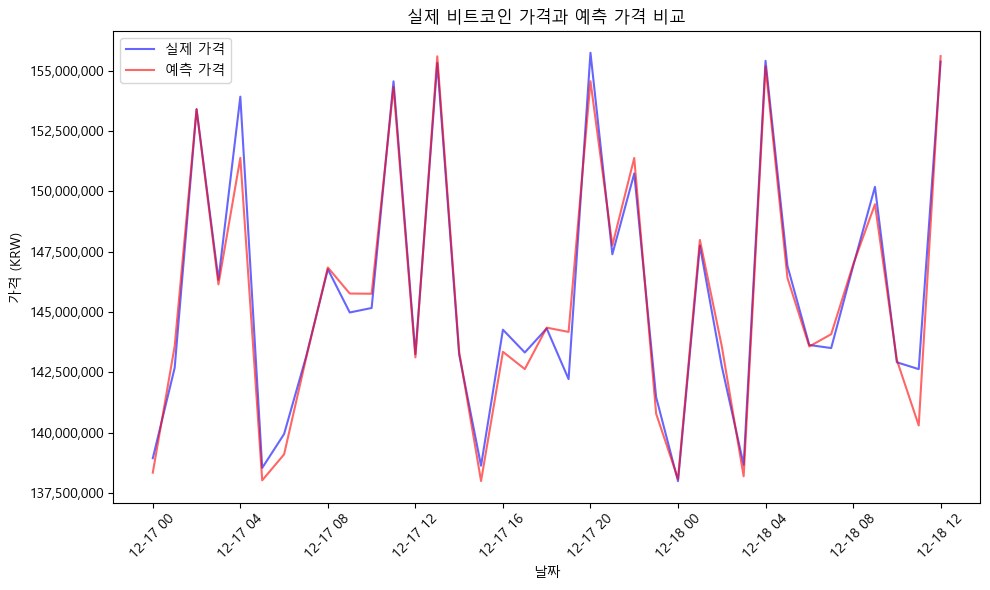

In [33]:
# 예측값과 실제값 비교 시각화
plt.figure(figsize=(10, 6))
plt.plot(merged_df['time'][-len(original_scale_y_test):], original_scale_y_test, label='실제 가격', color='blue', alpha=0.6)
plt.plot(merged_df['time'][-len(original_scale_predictions):], original_scale_predictions, label='예측 가격', color='red', alpha=0.6)

# Y축 포맷 설정
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.title('실제 비트코인 가격과 예측 가격 비교')
plt.xlabel('날짜')
plt.ylabel('가격 (KRW)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [34]:
results_df = pd.DataFrame({
    "Actual Price": original_scale_y_test.flatten(),
    "Predicted Price": original_scale_predictions.flatten()
})


In [35]:
merged_df

,time,price,sentiment,scaled_price,scaled_sentiment
0,2024-12-10 05:00:00,137213000.0,2.500000,0.029652,0.375
1,2024-12-10 06:00:00,138397000.0,2.500000,0.087206,0.375
2,2024-12-10 07:00:00,138380000.0,2.500000,0.086380,0.375
3,2024-12-10 08:00:00,138864000.0,2.500000,0.109907,0.375
4,2024-12-10 09:00:00,139005000.0,2.500000,0.116761,0.375
...,...,...,...,...,...
195,2024-12-18 08:00:00,155223000.0,2.500000,0.905114,0.375
196,2024-12-18 09:00:00,155010000.0,2.500000,0.894760,0.375
197,2024-12-18 10:00:00,154396000.0,2.500000,0.864913,0.375
198,2024-12-18 11:00:00,153865000.0,2.400000,0.839102,0.000


In [36]:
# 2. 날짜별 비트코인 가격과 감정 점수 정리
merged_df_sorted = merged_df.sort_values("time")
price_and_sentiment_df = merged_df_sorted[["time", "price", "scaled_sentiment"]]

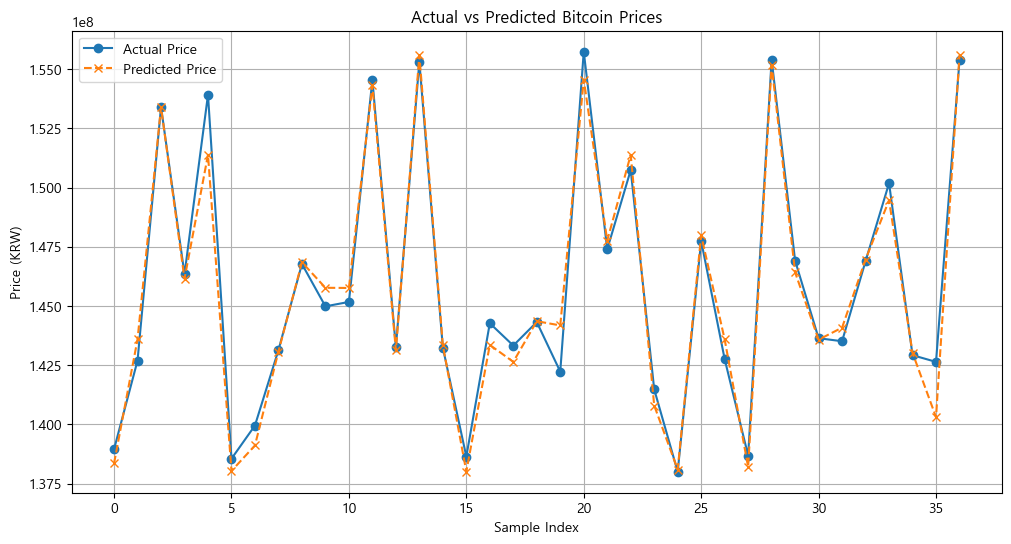

In [37]:

# 1. 예측 값과 실제 값 비교 그래프
plt.figure(figsize=(12, 6))
plt.plot(results_df.index, results_df["Actual Price"], label="Actual Price", linestyle="-", marker="o")
plt.plot(results_df.index, results_df["Predicted Price"], label="Predicted Price", linestyle="--", marker="x")
plt.title("Actual vs Predicted Bitcoin Prices")
plt.xlabel("Sample Index")
plt.ylabel("Price (KRW)")
plt.legend()
plt.grid(True)
plt.show()

In [40]:
# 비트코인이 오를지 안 오를지 판단하는 함수 추가
def predict_bitcoin_trend(predictions, actual_values):
    """
    예측값과 실제값을 기반으로 비트코인의 상승 또는 하락 여부를 판단
    """
    if len(predictions) == 0 or len(actual_values) == 0:
        return "예측 데이터를 확인할 수 없습니다."

    latest_prediction = predictions[-1][0]  # 가장 최신 예측값
    latest_actual = actual_values[-1][0]    # 가장 최신 실제값

    if latest_prediction > latest_actual:
        return f"비트코인의 가격이 오를 것으로 예측됩니다. (예측값: {latest_prediction:,.2f} KRW)"
    elif latest_prediction < latest_actual:
        return f"비트코인의 가격이 내릴 것으로 예측됩니다. (예측값: {latest_prediction:,.2f} KRW)"
    else:
        return "비트코인의 가격이 변동이 없을 것으로 예측됩니다."

# 예측값과 실제값 복원
predictions = model.predict(X_test)
original_scale_predictions = price_scaler.inverse_transform(predictions)
original_scale_y_test = price_scaler.inverse_transform(y_test.reshape(-1, 1))

# 결과 출력
print("샘플 예측값과 실제값:")
for pred, true in zip(original_scale_predictions[:5], original_scale_y_test[:5]):
    print(f"예측값: {pred[0]:,.2f}, 실제값: {true[0]:,.2f}")

# 비트코인 상승/하락 여부 출력
trend_prediction = predict_bitcoin_trend(original_scale_predictions, original_scale_y_test)
print(trend_prediction)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
샘플 예측값과 실제값:
예측값: 138,350,784.00, 실제값: 138,949,000.00
예측값: 143,590,192.00, 실제값: 142,693,000.00
예측값: 153,395,696.00, 실제값: 153,403,000.00
예측값: 146,145,792.00, 실제값: 146,340,000.00
예측값: 151,383,984.00, 실제값: 153,921,000.00
비트코인의 가격이 오를 것으로 예측됩니다. (예측값: 155,597,744.00 KRW)


In [41]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# 모델 정확도 지표 계산 함수
def evaluate_model(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return rmse, mse, mae, r2

# 예측값과 실제값 복원
predictions = model.predict(X_test)
original_scale_predictions = price_scaler.inverse_transform(predictions)
original_scale_y_test = price_scaler.inverse_transform(y_test.reshape(-1, 1))

# 정확도 지표 계산
rmse, mse, mae, r2 = evaluate_model(original_scale_y_test, original_scale_predictions)

# 정확도 지표 출력
print("\n모델 정확도 지표:")
print(f"RMSE (Root Mean Squared Error): {rmse:,.2f}")
print(f"MSE (Mean Squared Error): {mse:,.2f}")
print(f"MAE (Mean Absolute Error): {mae:,.2f}")
print(f"R² (결정 계수): {r2:.4f}")

# 샘플 예측값과 실제값 출력
print("\n샘플 예측값과 실제값:")
for pred, true in zip(original_scale_predictions[:5], original_scale_y_test[:5]):
    print(f"예측값: {pred[0]:,.2f}, 실제값: {true[0]:,.2f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

모델 정확도 지표:
RMSE (Root Mean Squared Error): 827,253.05
MSE (Mean Squared Error): 684,347,604,334.70
MAE (Mean Absolute Error): 577,996.97
R² (결정 계수): 0.9755

샘플 예측값과 실제값:
예측값: 138,350,784.00, 실제값: 138,949,000.00
예측값: 143,590,192.00, 실제값: 142,693,000.00
예측값: 153,395,696.00, 실제값: 153,403,000.00
예측값: 146,145,792.00, 실제값: 146,340,000.00
예측값: 151,383,984.00, 실제값: 153,921,000.00


In [42]:
# 결과 출력
print("샘플 예측값과 실제값:")
for pred, true in zip(original_scale_predictions[:5], original_scale_y_test[:5]):
    print(f"예측값: {pred[0]:,.2f} KRW, 실제값: {true[0]:,.2f} KRW")


샘플 예측값과 실제값:
예측값: 138,350,784.00 KRW, 실제값: 138,949,000.00 KRW
예측값: 143,590,192.00 KRW, 실제값: 142,693,000.00 KRW
예측값: 153,395,696.00 KRW, 실제값: 153,403,000.00 KRW
예측값: 146,145,792.00 KRW, 실제값: 146,340,000.00 KRW
예측값: 151,383,984.00 KRW, 실제값: 153,921,000.00 KRW
